# PIKs and time series :


In [ ]:
pip install torch

In [ ]:
pip install matplotlib

In [ ]:
pip install pandas

## I. Package PIK

### i. PIKL

In [ ]:
# Allows to automatically switch from CPU to GPU
import torch
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

def is_running_on_gpu():
  if torch.cuda.is_available():
    print("The algorithm is running on GPU.")
  else:
    print("The algorithm is not running on GPU.")

On commence par calculer la diagonale de la matrice $M$. Puis on crée la matrice à partir de sa diagonale (meilleure complexité).

In [2]:
def Sob_elementary(alpha, s, m):
    Sob_elem = torch.cat((torch.arange(-m, 0, device=device), torch.arange(1, m+1, device=device)))
    return alpha*(1+Sob_elem**(2*s))

def Sob_matrix(alpha_list, s_list, m_list):
    Sob_diag = torch.tensor([alpha_list[0]], device=device)
    d = len(s_list)
    for i in range(d):
        Sob_diag = torch.cat((Sob_diag, Sob_elementary(alpha_list[i+1], s_list[i], m_list[i])))
    return torch.diag(Sob_diag)

In [3]:
def mat_frequency(m_list,n):
    frequencies = torch.tensor([0], device=device)
    for m in m_list:
        frequencies = torch.cat((frequencies, torch.arange(-m, 0, device=device), torch.arange(1, m+1, device=device)))
    return torch.tile(frequencies,(n,1))

def mat_data(x_data, m_list, n):
    mat = torch.tensor([[0] for i in range(n)], device=device)
    d = len(m_list)
    for i in range(d):
        mat = torch.cat((mat, torch.tile(x_data[:, i].view(-1,1), (1, 2*m_list[i]))), dim=1)
    return mat

def phi_matrix(x_data, m_list):
    n = len(x_data)
    return torch.exp(-1j*torch.mul(mat_data(x_data, m_list, n),mat_frequency(m_list, n))/2)


In [4]:
def regression_vector(x_data, y_data, m_list, alpha_list, s_list):
    covariance_matrix_X = torch.conj_physical(torch.transpose(phi_matrix(x_data, m_list), 0,1))@phi_matrix(x_data, m_list)
    covariance_XY = torch.conj_physical(torch.transpose(phi_matrix(x_data, m_list), 0,1))@y_data
    M = Sob_matrix(alpha_list, s_list, m_list)
    return torch.linalg.solve(covariance_matrix_X+len(x_data)*M, covariance_XY)

In [5]:
def estimation(fourier_coefs, z_data, m_list):
    return phi_matrix(z_data, m_list)@fourier_coefs

### ii. Pakage PIKL Kalman

In [20]:
def mat_weight_kalman(x_data, m_list, n):
    mat = torch.tensor([[1] for i in range(n)], device=device)
    d = len(m_list)
    for i in range(d):
        mat = torch.cat((mat, torch.tile(x_data[:, i].view(-1,1), (1, 2*m_list[i]))), dim=1)
    return mat

def mat_data_kalman(x_data, m_list, n):
    ### Time must be the last feature
    mat = torch.tensor([[0] for i in range(n)], device=device)
    d = len(m_list)
    for i in range(d):
        mat = torch.cat((mat, torch.tile(x_data[:, -1].view(-1,1), (1, 2*m_list[i]))), dim=1)
    return mat

def phi_matrix_kalman(x_data, m_list):
    n = len(x_data)
    return torch.mul(mat_weight_kalman(x_data, m_list, n), torch.exp(-1j*torch.mul(mat_data_kalman(x_data, m_list, n),mat_frequency(m_list, n))/2))


In [25]:
def regression_vector_kalman(x_data, y_data, m_list, alpha_list, s_list):
    covariance_matrix_X = torch.conj_physical(torch.transpose(phi_matrix_kalman(x_data, m_list), 0,1))@phi_matrix_kalman(x_data, m_list)
    covariance_XY = torch.conj_physical(torch.transpose(phi_matrix_kalman(x_data, m_list), 0,1))@y_data
    M = Sob_matrix(alpha_list, s_list, m_list)
    return torch.linalg.solve(covariance_matrix_X+len(x_data)*M, covariance_XY)

In [26]:
def estimation_kalman(fourier_coefs, z_data, m_list):
    return phi_matrix_kalman(z_data, m_list)@fourier_coefs

## II. Unit tests

In [9]:
alpha_list=[1, 1, 0]
s_list = [1,2]
m_list=[1, 2]
Sob_matrix(alpha_list, s_list, m_list)

tensor([[1, 0, 0, 0, 0, 0, 0],
        [0, 2, 0, 0, 0, 0, 0],
        [0, 0, 2, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0]])

In [10]:
print(mat_frequency([1,2], 2))
print(mat_data(torch.tensor([[1,2], [2,3], [3,4]]), [1,2], 3)) #n=3, d=2
print(phi_matrix(torch.tensor([[1,2], [2,3], [3,4]]), [1,2]).size())
print(phi_matrix(torch.tensor([[1,2], [2,3], [3,4]]), [1,2]))

tensor([[ 0, -1,  1, -2, -1,  1,  2],
        [ 0, -1,  1, -2, -1,  1,  2]])
tensor([[0, 1, 1, 2, 2, 2, 2],
        [0, 2, 2, 3, 3, 3, 3],
        [0, 3, 3, 4, 4, 4, 4]])
torch.Size([3, 7])
tensor([[ 1.0000-0.0000j,  0.8776+0.4794j,  0.8776-0.4794j, -0.4161+0.9093j,
          0.5403+0.8415j,  0.5403-0.8415j, -0.4161-0.9093j],
        [ 1.0000-0.0000j,  0.5403+0.8415j,  0.5403-0.8415j, -0.9900+0.1411j,
          0.0707+0.9975j,  0.0707-0.9975j, -0.9900-0.1411j],
        [ 1.0000-0.0000j,  0.0707+0.9975j,  0.0707-0.9975j, -0.6536-0.7568j,
         -0.4161+0.9093j, -0.4161-0.9093j, -0.6536+0.7568j]])


In [11]:
x_data = torch.tensor([[1,2], [2,3], [3,4]])
y_data = torch.tensor([1,3, 1]).view(-1,1)*(1+0*1j)
m_list = [1,2]
alpha_list = [1,1,1]
s_list = [1,1]
z_data = torch.tensor([[1,2], [2,3], [3,4], [5,6], [7,8]])
estimation(regression_vector(x_data, y_data, m_list, alpha_list, s_list), z_data, m_list)

tensor([[ 1.2121+2.9802e-08j],
        [ 1.3968+0.0000e+00j],
        [ 1.2121-7.4506e-09j],
        [ 0.2697-7.4506e-09j],
        [-0.2125+7.4506e-09j]])

In [24]:
import pandas as pd
data = pd.DataFrame({"color": [1,2,3,0], "lum": [-1,-2,-3,-4], "time":[0,3,4,5]})
x_data = torch.tensor(data.values)
print(x_data)
m_list=[1,1, 2]
phi_matrix_kalman(x_data, m_list)

tensor([[ 1, -1,  0],
        [ 2, -2,  3],
        [ 3, -3,  4],
        [ 0, -4,  5]])


tensor([[ 1.0000+0.0000j,  1.0000+0.0000j,  1.0000+0.0000j, -1.0000+0.0000j,
         -1.0000+0.0000j,  0.0000+0.0000j,  0.0000+0.0000j,  0.0000+0.0000j,
          0.0000+0.0000j],
        [ 1.0000+0.0000j,  0.1415+1.9950j,  0.1415-1.9950j, -0.1415-1.9950j,
         -0.1415+1.9950j, -2.9700+0.4234j,  0.2122+2.9925j,  0.2122-2.9925j,
         -2.9700-0.4234j],
        [ 1.0000+0.0000j, -1.2484+2.7279j, -1.2484-2.7279j,  1.2484-2.7279j,
          1.2484+2.7279j, -2.6146-3.0272j, -1.6646+3.6372j, -1.6646-3.6372j,
         -2.6146+3.0272j],
        [ 1.0000+0.0000j, -0.0000+0.0000j,  0.0000-0.0000j,  3.2046-2.3939j,
          3.2046+2.3939j,  1.4183-4.7946j, -4.0057+2.9924j, -4.0057-2.9924j,
          1.4183+4.7946j]])

In [31]:
y_data = torch.tensor([1, 1, 3, 3.1])*(1+0*1j)
alpha_list = [10**-20, 10**-20, 10**-20, 10**-20]
s_list = [2, 2, 2]
fourier_vector_k = regression_vector_kalman(x_data, y_data, m_list, alpha_list, s_list)
test = data = pd.DataFrame({"color": [1,0], "lum": [-1,-4], "time":[0,5]})
z_data = torch.tensor(data.values)
estimation_kalman(fourier_vector_k, z_data, m_list)

tensor([1.0000+1.4305e-06j, 3.1000+4.7684e-07j])

## III. Test données réelles: including holidays / without Orange data

In [32]:
import pandas as pd
import numpy as np

df = pd.read_csv('dataset_national.csv')

In [10]:
df.keys()

Index(['Unnamed: 0', 'date', 'Date', 'tod', 'Load', 'Load_d1', 'Load_d7',
       'temperature', 'temperature_smooth_990', 'temperature_smooth_950',
       'temperature_max_smooth_990', 'temperature_max_smooth_950',
       'temperature_min_smooth_990', 'temperature_min_smooth_950', 'month',
       'year', 'toy', 'day_type_jf', 'day_type_ljf', 'day_type_vjf',
       'day_type_week', 'day_type_week_jf', 'day_type_hc',
       'period_hour_changed', 'period_holiday', 'period_holiday_zone_a',
       'period_holiday_zone_b', 'period_holiday_zone_c', 'period_christmas',
       'period_summer', 'day_type_week_period_hour_changed',
       'day_type_week_jf_period_holiday', 'week_number', 'DayValidity'],
      dtype='object')

In [33]:
columns = ["date", "tod", 
           "Load", "Load_d1", "Load_d7",
           "temperature_smooth_950", "temperature", "temperature_max_smooth_990", 'temperature_min_smooth_950',
            'toy', 'day_type_week', "day_type_jf"]
df_raw = df[columns].copy()
df_raw['day_type_week']=np.float64(df_raw.loc[:,'day_type_week'])

n = len(df_raw['date'])
df_raw['time'] = [i/n*np.pi for i in range(n)]


### i. PIKL

In [34]:
def normalize(dataset):
    data_min, data_max = np.min(dataset, axis=0), np.max(dataset, axis=0)
    center = (data_min+data_max)/2
    amplitude = data_max-data_min
    return (dataset - center)/amplitude*2*torch.pi

In [35]:
begin_train = "2013-08-01 00:00:00+00:00"
end_train = "2022-09-01 00:00:00+00:00"
end_test = "2023-02-28 00:00:00+00:00"

features = ["Load_d1", 
           "temperature_smooth_950", "temperature", "temperature_max_smooth_990", 'temperature_min_smooth_950',
            'toy',  'day_type_week', 'day_type_jf', 'Load_d7']

d=4
s_list = [2, 2, 2,2,2, 10, 0, 0, 4]
m_list = [30, 30, 30, 20, 20, 10, 4, 2, 10]
alpha_list = [10**-5, 10**-4, 10**-4, 10**-4, 10**-4,  10**-4, 10**-10, 10**-30, 10**-30, 10**-6] #attention au terme constant

h_list = [i for i in range(48)]
rmse_list, mape_list = [], []
fourier_vectors=[]

for h in h_list:
    df_h = df_raw[df_raw.tod == h]
    df_h.loc[:,features]=normalize(df_h[features]).loc[:,features]

    df_train = df_h[(df_h['date']>= begin_train)&(df_h['date']< end_train)] 
    df_test = df_h[(df_h['date']>= end_train)&(df_h['date']< end_test)] 

    x_data = torch.tensor(df_train[features].values)
    y_data = torch.tensor(df_train["Load"].values).view(-1,1)*(1+0*1j)

    x_test = torch.tensor(df_test[features].values)
    ground_truth = torch.tensor(df_test["Load"].values).view(-1,1)

    fourier_vector = regression_vector(x_data, y_data, m_list, alpha_list, s_list)
    fourier_vectors.append(fourier_vector)
    estimator = torch.real(estimation(fourier_vector, x_test, m_list)).view(-1)
    ground_truth = ground_truth.view(-1)
    
    rmse= torch.sqrt(torch.mean(torch.square(estimator-ground_truth))).item()
    mape = torch.mean(torch.abs((estimator-ground_truth)/ground_truth)).item()
    rmse_list.append(rmse)
    mape_list.append(mape)

The mean RMSE is 1810.1531867229903
The mean MAPE is 2.713143048542676%


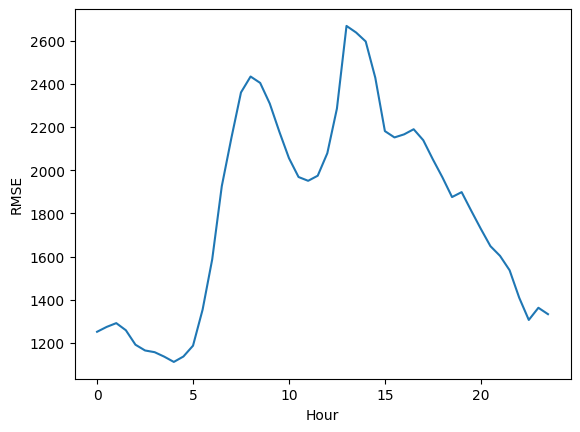

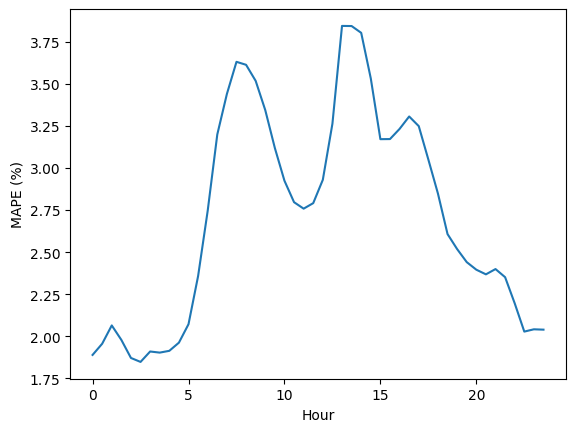

In [36]:
import matplotlib.pyplot as plt 

print("The mean RMSE is "+str(np.mean(rmse_list)))
print("The mean MAPE is "+str(np.mean(mape_list)*100)+"%")

plt.figure()
plt.plot(np.array(h_list)/2, rmse_list)
plt.xlabel("Hour")
plt.ylabel("RMSE")
plt.show()

plt.figure()
plt.plot(np.array(h_list)/2, np.array(mape_list)*100)
plt.xlabel("Hour")
plt.ylabel("MAPE (%)")
plt.show()


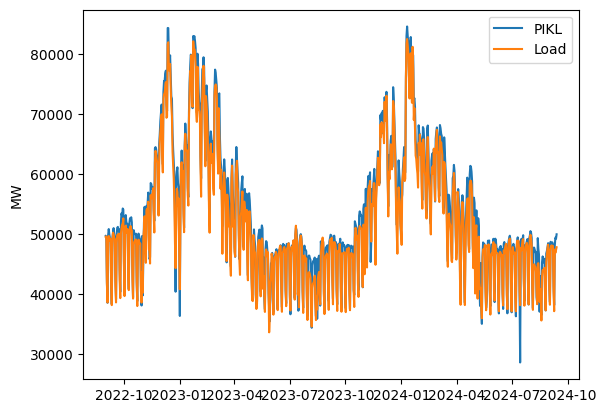

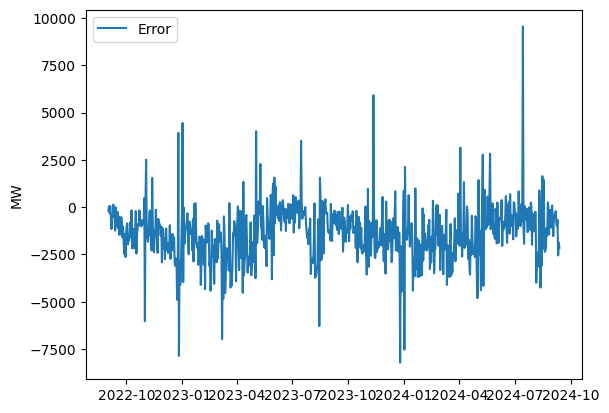

In [66]:
h=20
df_h = df_raw[df_raw.tod == h]
df_h.loc[:,features]=normalize(df_h[features]).loc[:,features]

df_train = df_h[(df_h['date']>= begin_train)&(df_h['date']< end_train)] 
df_test = df_h[df_h['date']>= end_train] 

x_data = torch.tensor(df_train[features].values)
y_data = torch.tensor(df_train["Load"].values).view(-1,1)*(1+0*1j)

x_test = torch.tensor(df_test[features].values)
ground_truth = torch.tensor(df_test["Load"].values).view(-1,1)

estimator = torch.real(estimation(regression_vector(x_data, y_data, m_list, alpha_list, s_list), x_test, m_list)).view(-1)

plt.figure()
plt.plot(pd.to_datetime(df_test['date']), estimator, label="PIKL")
plt.plot(pd.to_datetime(df_test['date']),ground_truth.view(-1), label="Load")
plt.ylabel("MW")
plt.legend()
plt.show()

plt.figure()
plt.plot(pd.to_datetime(df_test['date']),ground_truth.view(-1)- estimator, label="Error")
plt.ylabel("MW")
plt.legend()
plt.show()

In [37]:
def transform(df, m_list, fourier_vector, features):
    g_h = pd.DataFrame()
    g_h['Load'] = df['Load']
    g_h['date']=df['date']
    g_h['PIKL'] = torch.real(estimation(fourier_vector, torch.tensor(df_h[features].values), m_list)).view(-1).numpy()
    g_h["error"]=df["Load"]-g_h['PIKL']
    phi_mat = phi_matrix(torch.tensor(df[features].values), m_list)
    
    current = 1
    for j in range(len(features)):
        partial_fourier = fourier_vector[current:current+2*m_list[j]]
        g_h[features[j]] = (phi_mat[:, current:current+2*m_list[j]]@partial_fourier).view(-1)
        current+= 2*m_list[j]
    return g_h

### Visualize effects


Load_d1


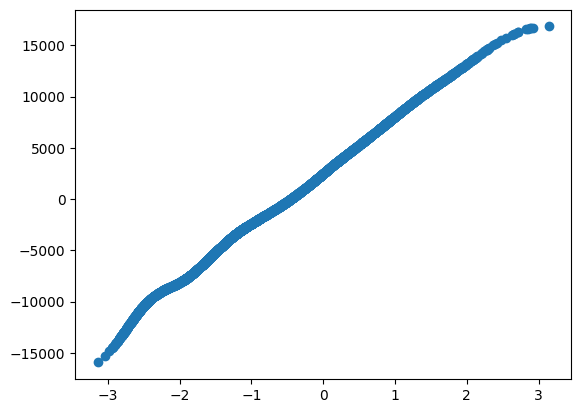

temperature_smooth_950


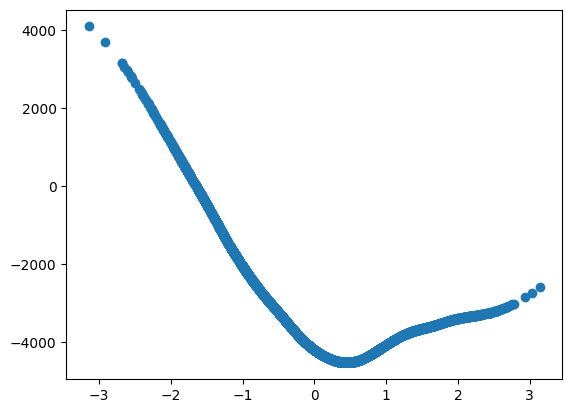

temperature


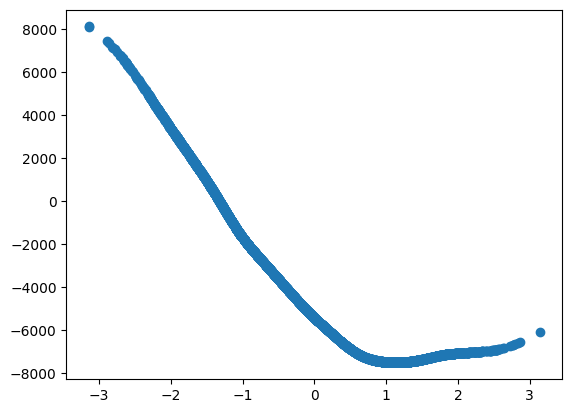

temperature_max_smooth_990


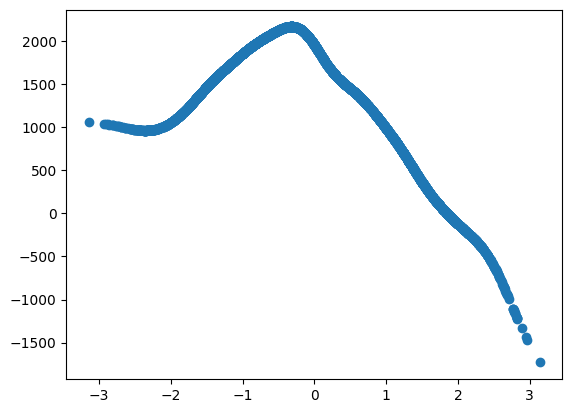

temperature_min_smooth_950


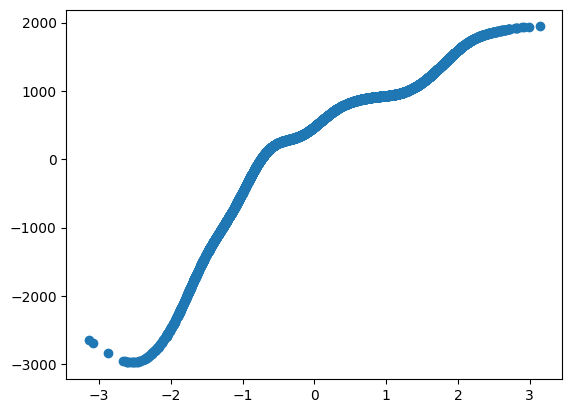

toy


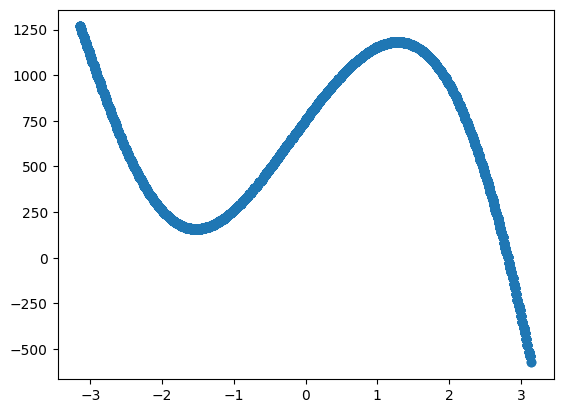

day_type_week


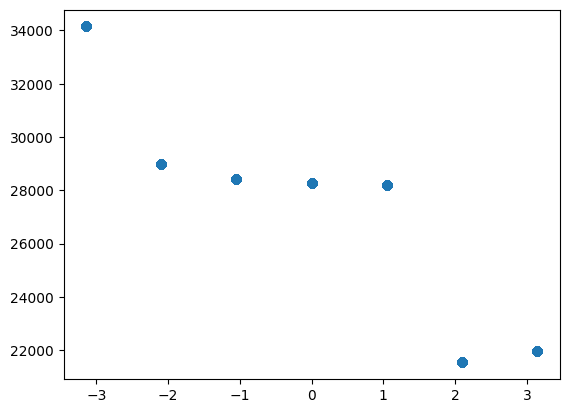

day_type_jf


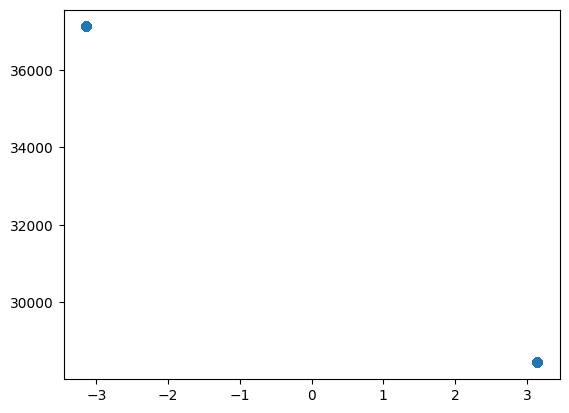

Load_d7


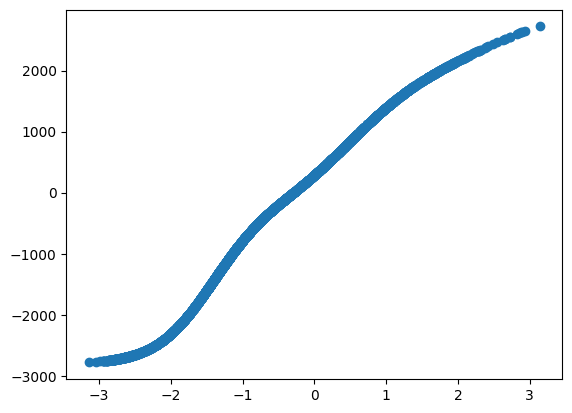

In [67]:
df_h = df_raw[df_raw.tod == h]
df_h.loc[:,features]=normalize(df_h[features]).loc[:,features]

h=20
g_h=transform(df_h, m_list, fourier_vectors[h], features)

for feature in features:
    print(feature)
    plt.figure()
    plt.scatter(df_h[feature], np.real(g_h[feature]))
    plt.show()

### ii. Kalmann PIKL

In [41]:
features

['Load_d1',
 'temperature_smooth_950',
 'temperature',
 'temperature_max_smooth_990',
 'temperature_min_smooth_950',
 'toy',
 'day_type_week',
 'day_type_jf',
 'Load_d7']

In [51]:
from datetime import timedelta

rmse_online, mape_online = [], []
s_online = [4, 4, 4,4,4, 4, 4, 10, 2, 2]
m_online = [2, 2, 2, 2, 2, 10, 5, 10, 2, 10]
powers=[-10, -10, -8, -10, -10, -8, -10, -8, -2, -10, -8]
alpha_online = [10**power for power in powers] #attention au terme constant
window=7

for h in h_list:
    df_h = df_raw[df_raw.tod == h]
    df_h.loc[:,features]=normalize(df_h[features]).loc[:,features]

    g_h=transform(df_h, m_list, fourier_vectors[h], features)
    features_g = features + ['time']
    g_h['time']= df_h['time'].values*(1+0*1j)
    g_h.loc[:,features_g]=normalize(g_h[features_g]).loc[:,features_g]

    current_end_train = pd.to_datetime(end_train)
    current_end_test = pd.to_datetime(end_train) +  timedelta(days=window)
    estimator_online = torch.tensor([])

    g_h['date'] = pd.to_datetime(g_h['date'])

    while current_end_train  < pd.to_datetime(end_test):
        g_train = g_h[(g_h['date']>= begin_train)&(g_h['date']< current_end_train)] 
        g_test = g_h[(g_h['date']>= current_end_train)&(g_h['date']< current_end_test)] 

        x_online = torch.tensor(g_train[features_g].values)
        y_online = torch.tensor(g_train["error"].values).view(-1,1)*(1+0*1j)

        x_test_online  = torch.tensor(g_test[features_g].values)
        ground_truth_online  = torch.tensor(g_test["Load"].values).view(-1,1)

        fourier_vector_online = regression_vector_kalman(x_online , y_online , m_online , alpha_online , s_online )
        estimator_online = torch.cat((estimator_online,torch.tensor(g_test['PIKL'].values) + torch.real(estimation_kalman(fourier_vector_online , x_test_online , m_online)).view(-1)))
        
        current_end_train = current_end_train + timedelta(days=window) 
        current_end_test = min(current_end_test+  timedelta(days=window), pd.to_datetime(end_test))

    g_test = g_h[(g_h['date']>= end_train)&(g_h['date']< end_test)] 
    ground_truth_online  = torch.tensor(g_test['Load'].values)

    rmse= torch.sqrt(torch.mean(torch.square(estimator_online -ground_truth_online))).item()
    mape = torch.mean((torch.abs((estimator_online -ground_truth_online )/ground_truth_online))).item()
    rmse_online.append(rmse)
    mape_online.append(mape)
    print("h = "+str(h))

h = 0
h = 1
h = 2
h = 3
h = 4
h = 5
h = 6
h = 7
h = 8
h = 9
h = 10
h = 11
h = 12
h = 13
h = 14
h = 15
h = 16
h = 17
h = 18
h = 19
h = 20
h = 21
h = 22
h = 23
h = 24
h = 25
h = 26
h = 27
h = 28
h = 29
h = 30
h = 31
h = 32
h = 33
h = 34
h = 35
h = 36
h = 37
h = 38
h = 39
h = 40
h = 41
h = 42
h = 43
h = 44
h = 45
h = 46
h = 47


The mean RMSE online is 1127.1428078989738
The mean MAPE online is 1.6261018881917066%


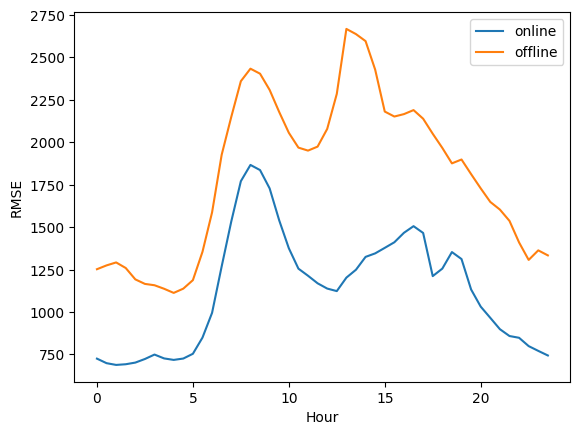

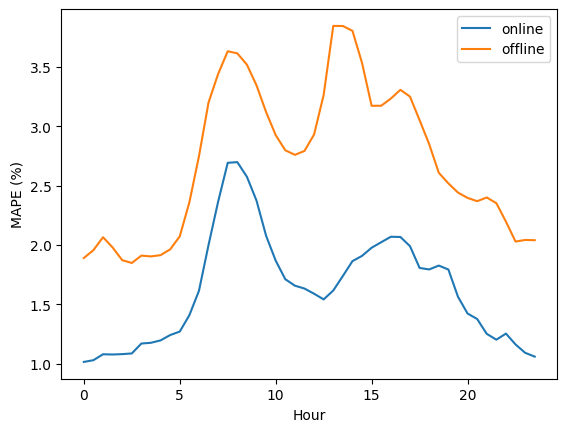

In [52]:
print("The mean RMSE online is "+str(np.mean(rmse_online)))
print("The mean MAPE online is "+str(np.mean(mape_online)*100)+"%")

plt.figure()
plt.plot(np.array(h_list)/2, rmse_online, label="online")
plt.plot(np.array(h_list)/2, rmse_list, label="offline")
plt.xlabel("Hour")
plt.ylabel("RMSE")
plt.legend()
plt.show()

plt.figure()
plt.plot(np.array(h_list)/2, np.array(mape_online)*100, label="online")
plt.plot(np.array(h_list)/2, np.array(mape_list)*100, label="offline")
plt.xlabel("Hour")
plt.ylabel("MAPE (%)")
plt.legend()
plt.show()


## IV. Without holidays

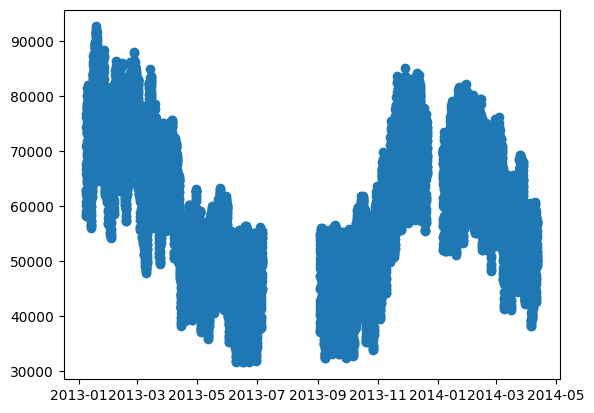

In [53]:
columns_holidays = ["date", "tod", "period_christmas", 'period_summer',
           "Load", "Load_d1", "Load_d7",
           "temperature_smooth_950", "temperature", "temperature_max_smooth_990", 'temperature_min_smooth_950',
            'toy', 'day_type_week', "day_type_jf"]
df_without_holidays = df[columns_holidays].copy()
df_without_holidays['day_type_week']=np.float64(df_without_holidays.loc[:,'day_type_week'])

holidays = np.where(df_without_holidays['day_type_jf'] == 1)[0]
holidays_24h_window = np.concatenate([holidays - 48, holidays, holidays + 48])

# Ensure indices are within bounds
holidays_24h_window = np.clip(holidays_24h_window, 0, len(df_without_holidays) - 1)

# Identifying outliers
outliers = np.unique(np.concatenate([
    holidays_24h_window,
    np.where(df_without_holidays['period_summer'] != 0)[0],
    np.where(df_without_holidays['period_christmas'] != 0)[0]
]))

df_without_holidays = df_without_holidays.drop(outliers)

plt.scatter(pd.to_datetime(df_without_holidays['date'])[:365*48], df_without_holidays['Load'][:365*48])

n = len(df_without_holidays['date'])
df_without_holidays['time'] = [i/n*np.pi for i in range(n)]


### i. PIKL

In [93]:
begin_train = "2013-08-01 00:00:00+00:00"
end_train = "2022-09-01 00:00:00+00:00"
end_test = "2023-02-28 00:00:00+00:00"

features = ["Load_d1", 
           "temperature_smooth_950", "temperature", "temperature_max_smooth_990", 'temperature_min_smooth_950',
            'toy',  'day_type_week', "Load_d7"]

d=4
s_list = [2, 2, 2,2,2, 10, 0, 4]
m_list = [30, 30, 30, 20, 20, 10, 4, 10]
alpha_list = [10**-5, 10**-4, 10**-4, 10**-4, 10**-4,  10**-4, 10**-10, 10**-30, 10**-6] #attention au terme constant

h_list = [i for i in range(48)]
rmse_list, mape_list = [], []
fourier_vectors=[]

for h in h_list:
    df_h = df_without_holidays[df_without_holidays.tod == h]
    df_h.loc[:,features]=normalize(df_h[features]).loc[:,features]

    df_train = df_h[(df_h['date']>= begin_train)&(df_h['date']< end_train)] 
    df_test = df_h[(df_h['date']>= end_train)&(df_h['date']< end_test)] 
    
    x_data = torch.tensor(df_train[features].values)
    y_data = torch.tensor(df_train["Load"].values).view(-1,1)*(1+0*1j)

    x_test = torch.tensor(df_test[features].values)
    ground_truth = torch.tensor(df_test["Load"].values).view(-1,1)

    fourier_vector = regression_vector(x_data, y_data, m_list, alpha_list, s_list)
    fourier_vectors.append(fourier_vector)
    estimator = torch.real(estimation(fourier_vector, x_test, m_list)).view(-1)
    ground_truth = ground_truth.view(-1)
    
    rmse= torch.sqrt(torch.mean(torch.square(estimator-ground_truth))).item()
    mape = torch.mean(torch.abs((estimator-ground_truth))/ground_truth).item()
    rmse_list.append(rmse)
    mape_list.append(mape)

The mean RMSE is 1576.092875480681
The mean MAPE is 2.357254034259769%


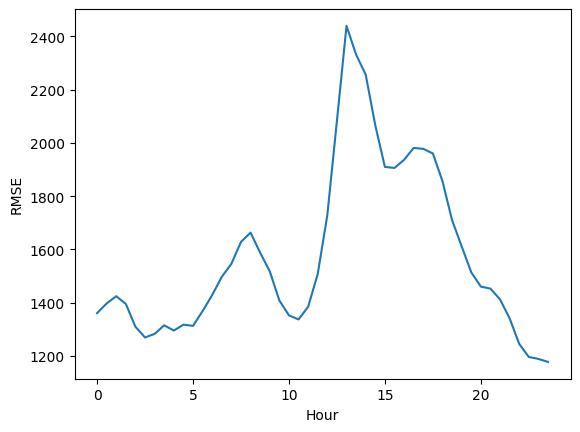

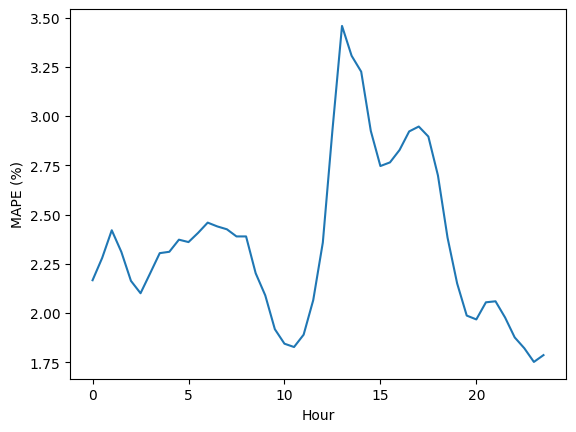

In [94]:
print("The mean RMSE is "+str(np.mean(rmse_list)))
print("The mean MAPE is "+str(np.mean(mape_list)*100)+"%")

plt.figure()
plt.plot(np.array(h_list)/2, rmse_list)
plt.xlabel("Hour")
plt.ylabel("RMSE")
plt.show()

plt.figure()
plt.plot(np.array(h_list)/2, np.array(mape_list)*100)
plt.xlabel("Hour")
plt.ylabel("MAPE (%)")
plt.show()

### ii. Kalman

In [63]:
features

['Load_d1',
 'temperature_smooth_950',
 'temperature',
 'temperature_max_smooth_990',
 'temperature_min_smooth_950',
 'toy',
 'day_type_week',
 'Load_d7']

In [108]:
from datetime import timedelta

rmse_online, mape_online = [], []
s_online = [4, 4, 4,4,4, 4, 4,  2, 2]
m_online = [0, 2, 2, 2, 2, 2, 4,  0, 10]
powers=[-10, -10, -8, -10, -10, -8, -10, -8,  -10, -8]
alpha_online = [10**power for power in powers] #attention au terme constant
window=7

for h in h_list:
    df_h = df_without_holidays[df_without_holidays.tod == h]
    df_h.loc[:,features]=normalize(df_h[features]).loc[:,features]

    g_h=transform(df_h, m_list, fourier_vectors[h], features)
    features_g = features + ['time']
    g_h['time']= df_h['time'].values*(1+0*1j)
    g_h.loc[:,features_g]=normalize(g_h[features_g]).loc[:,features_g]

    current_end_train = pd.to_datetime(end_train)
    current_end_test = pd.to_datetime(end_train) +  timedelta(days=window)
    estimator_online = torch.tensor([])

    g_h['date'] = pd.to_datetime(g_h['date'])

    while current_end_train  < pd.to_datetime(end_test):
        g_train = g_h[(g_h['date']>= begin_train)&(g_h['date']< current_end_train)] 
        g_test = g_h[(g_h['date']>= current_end_train)&(g_h['date']< current_end_test)] 

        x_online = torch.tensor(g_train[features_g].values)
        y_online = torch.tensor(g_train["error"].values).view(-1,1)*(1+0*1j)

        x_test_online  = torch.tensor(g_test[features_g].values)
        if x_test_online.shape[0] != 0:
            ground_truth_online  = torch.tensor(g_test["Load"].values).view(-1,1)
            fourier_vector_online = regression_vector_kalman(x_online , y_online , m_online , alpha_online , s_online )
            estimator_online = torch.cat((estimator_online,torch.tensor(g_test['PIKL'].values) + torch.real(estimation_kalman(fourier_vector_online , x_test_online , m_online)).view(-1)))
        
        current_end_train = current_end_train + timedelta(days=window) 
        current_end_test = min(current_end_test+  timedelta(days=window), pd.to_datetime(end_test))

    g_test = g_h[(g_h['date']>= end_train)&(g_h['date']< end_test)] 
    ground_truth_online  = torch.tensor(g_test['Load'].values)

    rmse= torch.sqrt(torch.mean(torch.square(estimator_online -ground_truth_online))).item()
    mape = torch.mean((torch.abs((estimator_online -ground_truth_online )/ground_truth_online))).item()
    rmse_online.append(rmse)
    mape_online.append(mape)
    print("h = "+str(h))

h = 0
h = 1
h = 2
h = 3
h = 4
h = 5
h = 6
h = 7
h = 8
h = 9
h = 10
h = 11
h = 12
h = 13
h = 14
h = 15
h = 16
h = 17
h = 18
h = 19
h = 20
h = 21
h = 22
h = 23
h = 24
h = 25
h = 26
h = 27
h = 28
h = 29
h = 30
h = 31
h = 32
h = 33
h = 34
h = 35
h = 36
h = 37
h = 38
h = 39
h = 40
h = 41
h = 42
h = 43
h = 44
h = 45
h = 46
h = 47


The mean RMSE online is 862.318850209918
The mean MAPE online is 1.1861027465810294%


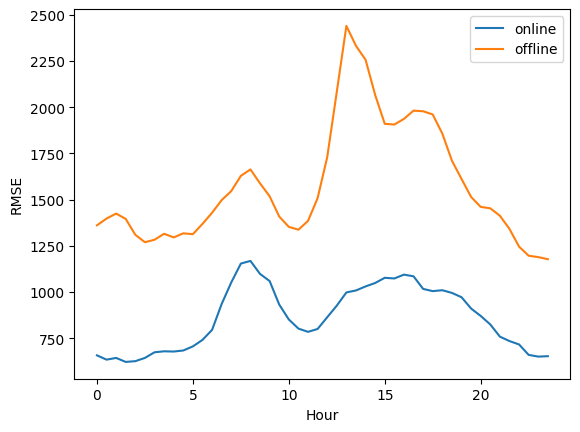

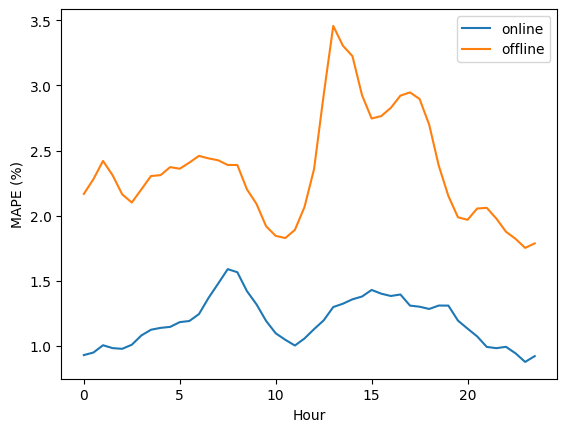

In [109]:
print("The mean RMSE online is "+str(np.mean(rmse_online)))
print("The mean MAPE online is "+str(np.mean(mape_online)*100)+"%")

plt.figure()
plt.plot(np.array(h_list)/2, rmse_online, label="online")
plt.plot(np.array(h_list)/2, rmse_list, label="offline")
plt.xlabel("Hour")
plt.ylabel("RMSE")
plt.legend()
plt.show()

plt.figure()
plt.plot(np.array(h_list)/2, np.array(mape_online)*100, label="online")
plt.plot(np.array(h_list)/2, np.array(mape_list)*100, label="offline")
plt.xlabel("Hour")
plt.ylabel("MAPE (%)")
plt.legend()
plt.show()
